In [1]:
# !pip install tensorflow==2.14.0 tensorflow-probability==0.22.0

In [2]:
import numpy as np
import numpy as np
import tensorflow as tf
import random
import tf_agents.environments as tf_env
import tf_agents.specs as tf_specs
from tf_agents.trajectories import time_step as ts
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

User profile with base change probability 0.49 and lambda fatigue 0.07
True values: -0.011031404416317558
Value estimates: [-0.3        -0.71428571 -1.         -1.          0.98731501]
Action counts: [ 10.   7.   5.   5. 473.]
User profile with base change probability 0.31 and lambda fatigue 0.03
True values: -0.37112290692470373
Value estimates: [-0.44444444 -0.71428571 -1.         -1.          0.96624473]
Action counts: [  9.   7.   5.   5. 474.]
User profile with base change probability 0.43 and lambda fatigue 0.07
True values: -0.14896398423444102
Value estimates: [-0.3        -0.66666667 -1.         -1.          0.99156118]
Action counts: [ 10.   6.   5.   5. 474.]
User profile with base change probability 0.17 and lambda fatigue 0.09
True values: -0.669906448524087
Value estimates: [-0.83333333 -1.         -1.         -1.          0.99164927]
Action counts: [  6.   5.   5.   5. 479.]
User profile with base change probability 0.43 and lambda fatigue 0.10
True values: -0.1419702056

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

User profile with base change probability 0.21 and lambda fatigue 0.01
True values: -0.581274342455435
Value estimates: [-0.36363636 -1.         -0.71428571 -1.          0.91525424]
Action counts: [ 11.   5.   7.   5. 472.]
User profile with base change probability 0.45 and lambda fatigue 0.08
True values: -0.10822209899595747
Value estimates: [-0.3        -0.66666667 -1.         -1.          0.99578059]
Action counts: [ 10.   6.   5.   5. 474.]
User profile with base change probability 0.50 and lambda fatigue 0.10
True values: -0.00022586137109548154
Value estimates: [-0.3        -0.66666667 -1.         -1.          0.99578059]
Action counts: [ 10.   6.   5.   5. 474.]
User profile with base change probability 0.32 and lambda fatigue 0.08
True values: -0.355654635517898
Value estimates: [-0.44444444 -1.         -1.         -1.          0.99159664]
Action counts: [  9.   5.   5.   5. 476.]
User profile with base change probability 0.48 and lambda fatigue 0.09
True values: -0.0441874160

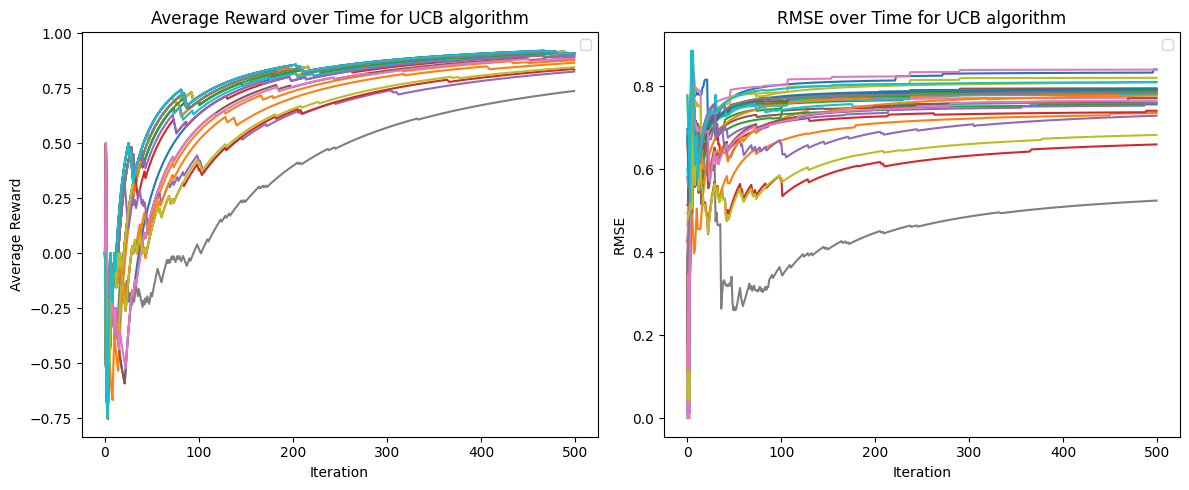

In [10]:
class FiveArmedBanditEnv(tf_env.py_environment.PyEnvironment):
    def __init__(self, user_model_vec, change_probability=0.3, lambda_fatigue=0.01, seed=42):
        self._num_actions = 5
        self._user_model_vec = user_model_vec
        self._change_probability = change_probability
        self._lambda_fatigue = lambda_fatigue
        self._step_count = 0
        self._total_reward = 0.0
        self._dummy_observation = np.array([0.0, 0.0, 0.0, 0.0, 0.0], dtype=np.float32)
        np.random.seed(seed)
        super(FiveArmedBanditEnv, self).__init__()

    def action_spec(self):
        return tf_specs.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=self._num_actions - 1, name='action')

    def observation_spec(self):
        return tf_specs.BoundedArraySpec(
            shape=(self._num_actions,), dtype=np.float32, minimum=0, name='observation')

    def _reset(self):
        self._step_count = 0
        self._total_reward = 0.0
        return ts.restart(observation=self._dummy_observation)
    
    def _step(self, action):
        fatigue = 1 - np.exp(-self._lambda_fatigue * self._step_count)
        adjusted_change_probability = self._change_probability * (1 - fatigue)

        if np.random.uniform(0, 1) < adjusted_change_probability:
            self.current_state = 'changed_posture'
        else:
            self.current_state = 'same_posture'

        # Define rewards based on the state and action
        if self.current_state == 'changed_posture':
            reward = 1 if action != 4 else -1  # Positive reward for any action except 'stay'
        else:
            reward = -1 if action != 4 else 1  # Negative reward for any action except 'stay'

        self._step_count += 1
        self._total_reward += reward

        return ts.transition(observation=self._dummy_observation, reward=reward)
    
    def get_total_reward(self):
        return self._total_reward

    def get_step_count(self):
        return self._step_count

def generate_user_profiles(num_profiles, base_change_probability_range, lambda_fatigue_range):
    user_profiles = []
    for _ in range(num_profiles):
        base_change_probability = np.random.uniform(*base_change_probability_range)
        lambda_fatigue = np.random.uniform(*lambda_fatigue_range)
        user_profiles.append((base_change_probability, lambda_fatigue))
    return user_profiles

class UCB1Agent:
    def __init__(self, num_actions, explore_rate=2.0):
        self.num_actions = num_actions
        self.explore_rate = explore_rate
        self.action_counts = np.zeros(num_actions)
        self.action_values = np.zeros(num_actions)
        self.total_steps = 0

    def select_action(self):
        ucb_values = self.action_values + self.explore_rate * np.sqrt(np.log(self.total_steps + 1) / (self.action_counts + 1))
        return np.argmax(ucb_values)

    def update_estimates(self, action, reward):
        self.total_steps += 1
        self.action_counts[action] += 1
        alpha = 1 / self.action_counts[action]
        self.action_values[action] += alpha * (reward - self.action_values[action])

    def get_current_average_reward(self):
        return np.sum(self.action_values * self.action_counts) / np.sum(self.action_counts)

def user_simulation(user_profiles, num_iterations=500, explore_rate=2.0):
    all_average_rewards = []
    all_rmse = []

    for base_change_probability, lambda_fatigue in user_profiles:
        # Create the environment
        env = FiveArmedBanditEnv(user_model_vec=None, change_probability=base_change_probability, lambda_fatigue=lambda_fatigue)

        # Create the UCB1 agent
        agent = UCB1Agent(num_actions=env.action_spec().maximum + 1, explore_rate=explore_rate)

        average_rewards = []
        rmse = []

        # Training loop
        for _ in range(num_iterations):
            # Main stepping
            action = agent.select_action()
            time_step = env.step(action)
            agent.update_estimates(action, time_step.reward)

            # Logs for plotting
            average_rewards.append(agent.get_current_average_reward())
            true_action_value = 2 * base_change_probability - 1
            rmse.append(np.sqrt(np.mean((np.subtract(agent.action_values, true_action_value))**2)))

        all_average_rewards.append(average_rewards)
        all_rmse.append(rmse)

        print(f"User profile with base change probability {base_change_probability:.2f} and lambda fatigue {lambda_fatigue:.2f}")
        print("True values: {}".format(true_action_value))
        print("Value estimates: {}".format(agent.action_values))
        print("Action counts: {}".format(agent.action_counts))

    return all_average_rewards, all_rmse

if __name__ == "__main__":
    num_profiles = 30 # We want enough profiles to see the variance in the results but not too many to stay feasible in the real experiment
    base_change_probability_range = (0.1, 0.5) # At minimum, the user changes posture 10% of the time and at maximum 50% of the time
    lambda_fatigue_range = (0.005, 0.1) # In the paper the values chosen were 0.01, 0.03 and 0.05
    
    user_profiles = generate_user_profiles(num_profiles, base_change_probability_range, lambda_fatigue_range)
    average_rewards, rmse = user_simulation(user_profiles)

    plt.figure(figsize=(12, 5))

    for i, (avg_rewards, rms) in enumerate(zip(average_rewards, rmse)):
        plt.subplot(1, 2, 1)
        plt.plot(avg_rewards)
        plt.xlabel('Iteration')
        plt.ylabel('Average Reward')
        plt.title('Average Reward over Time for UCB algorithm')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(rms)
        plt.xlabel('Iteration')
        plt.ylabel('RMSE')
        plt.title('RMSE over Time for UCB algorithm')
        plt.legend()

    plt.tight_layout()
    plt.show()


Iteration 1, Episode 1, Total Reward: 30.0
Iteration 1, Episode 2, Total Reward: 36.0
Iteration 1, Episode 3, Total Reward: 38.0
Iteration 1, Episode 4, Total Reward: 36.0
Iteration 1, Episode 5, Total Reward: 32.0
Iteration 1, Episode 6, Total Reward: 34.0
Iteration 1, Episode 7, Total Reward: 40.0
Iteration 1, Episode 8, Total Reward: 32.0
Iteration 1, Episode 9, Total Reward: 38.0
Iteration 1, Episode 10, Total Reward: 32.0
Iteration 1, Episode 11, Total Reward: 40.0
Iteration 1, Episode 12, Total Reward: 40.0
Iteration 1, Episode 13, Total Reward: 28.0
Iteration 1, Episode 14, Total Reward: 38.0
Iteration 1, Episode 15, Total Reward: 36.0
Iteration 1, Episode 16, Total Reward: 36.0
Iteration 1, Episode 17, Total Reward: 38.0
Iteration 1, Episode 18, Total Reward: 28.0
Iteration 1, Episode 19, Total Reward: 36.0
Iteration 1, Episode 20, Total Reward: 38.0
Iteration 1, Episode 21, Total Reward: 38.0
Iteration 1, Episode 22, Total Reward: 44.0
Iteration 1, Episode 23, Total Reward: 40

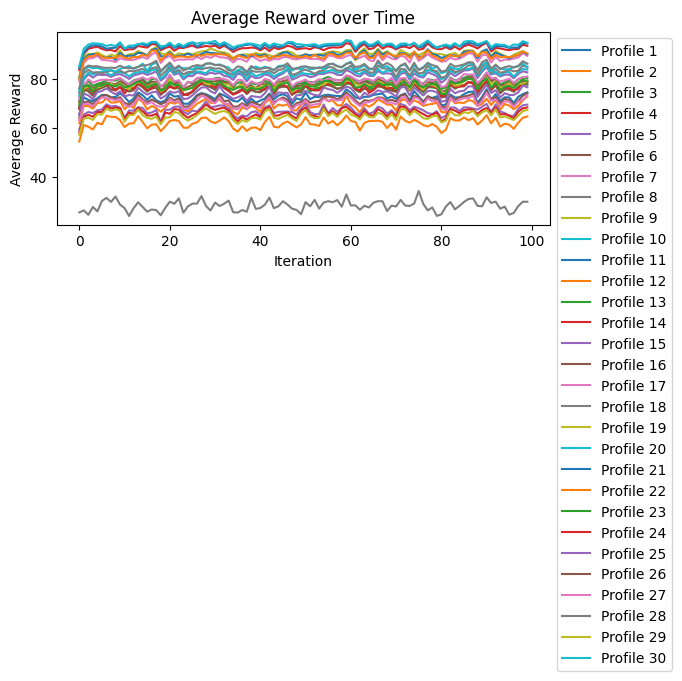

In [4]:
class QLearningAgent:
    def __init__(self, num_actions, num_states, num_episodes, alpha=0.1, gamma=0.99, epsilon=0.1, epsilon_decay=0.99):
        self.num_actions = num_actions
        self.num_states = num_states
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.q_table = np.zeros((num_states, num_actions))
        self.action_counts = np.zeros((num_states, num_actions))
        self.total_steps = num_episodes

    def select_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            action = random.randint(0, self.num_actions - 1)  # Explore
        else:
            action = np.argmax(self.q_table[state])  # Exploit
        return action

    def update_estimates(self, state, action, reward, next_state):
        self.total_steps += 1
        self.action_counts[state, action] += 1
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.gamma * self.q_table[next_state, best_next_action]
        td_error = td_target - self.q_table[state, action]
        self.q_table[state, action] += self.alpha * td_error
        self.epsilon *= self.epsilon_decay  # Decay epsilon

    def get_current_average_reward(self):
        total_rewards = np.sum(self.q_table * self.action_counts)
        total_counts = self.total_steps
        return total_rewards / total_counts if total_counts != 0 else 0

def user_simulation(user_profiles, num_iterations=100, num_episodes=50, alpha=0.1, gamma=0.99, epsilon=0.1, epsilon_decay=0.99):
    all_average_rewards = []
    all_rmse = []

    for base_change_probability, lambda_fatigue in user_profiles:
        # Create the environment
        env = FiveArmedBanditEnv(user_model_vec=None, change_probability=base_change_probability, lambda_fatigue=lambda_fatigue)

        # Create the Q-learning agent
        agent = QLearningAgent(num_actions=env.action_spec().maximum + 1, num_states=2, num_episodes=50, alpha=alpha, gamma=gamma, epsilon=epsilon, epsilon_decay=epsilon_decay)

        average_rewards = []
        rmse = []

        # Training loop
        for iteration in range(num_iterations):
            for episode in range(num_episodes):
                time_step = env.reset()
                state = 0 if time_step.observation[-1] == 0.0 else 1
                i=0

                while i<50:
                    action = agent.select_action(state)
                    time_step = env.step(action)
                    reward = time_step.reward
                    next_state = 0 if time_step.observation[-1] == 0.0 else 1
                    agent.update_estimates(state, action, reward, next_state)
                    state = next_state
                    i+=1

                print(f"Iteration {iteration + 1}, Episode {episode + 1}, Total Reward: {env.get_total_reward()}")

            # Logs for plotting
            average_rewards.append(agent.get_current_average_reward())
            true_action_value = 2 * base_change_probability - 1
            rmse.append(np.sqrt(np.mean((np.subtract(agent.q_table.mean(axis=0), true_action_value))**2)))

        all_average_rewards.append(average_rewards)
        all_rmse.append(rmse)

        print(f"User profile with base change probability {base_change_probability:.2f} and lambda fatigue {lambda_fatigue:.2f}")
        print("True values: {}".format(true_action_value))
        print("Q-values estimates: {}".format(agent.q_table.mean(axis=0)))
        print("Action counts: {}".format(agent.action_counts.sum(axis=0)))

    return all_average_rewards, all_rmse

if __name__ == "__main__":
    num_profiles = 30  # We want enough profiles to see the variance in the results but not too many to stay feasible in the real experiment
    base_change_probability_range = (0.1, 0.5)  # At minimum, the user changes posture 10% of the time and at maximum 50% of the time
    lambda_fatigue_range = (0.005, 0.1)  # In the paper the values chosen were 0.01, 0.03 and 0.05

    user_profiles = generate_user_profiles(num_profiles, base_change_probability_range, lambda_fatigue_range)
    average_rewards, rmse = user_simulation(user_profiles)

    plt.figure(figsize=(12, 5))

    for i, (avg_rewards, rms) in enumerate(zip(average_rewards, rmse)):
        plt.subplot(1, 2, 1)
        plt.plot(avg_rewards, label=f'Profile {i+1}')
        plt.xlabel('Iteration')
        plt.ylabel('Average Reward')
        plt.title('Average Reward over Time')
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.show()